In [215]:
import os
import sys
from collections import Counter

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
#from torchmetrics import F1Score, Accuracy
from transformers import BertTokenizer, BertForSequenceClassification, get_cosine_schedule_with_warmup, AdamW
from torch.utils.data.sampler import WeightedRandomSampler

from sklearn.model_selection import train_test_split
import plotly.figure_factory as ff
from matplotlib import pyplot as plt
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    accuracy_score,
    multilabel_confusion_matrix,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    precision_score,
    recall_score,
)

import re

import nltk
from nltk.corpus import stopwords
import string


In [216]:
import torch
import torch.nn as nn
from torch.nn.functional import one_hot
from torch import Tensor
from typing import Union

class FocalLoss(nn.Module):
    """Computes the focal loss between input and target
    as described here https://arxiv.org/abs/1708.02002v2

    Args:
        gamma (float):  The focal loss focusing parameter.
        weights (Union[None, Tensor]): Rescaling weight given to each class.
        If given, has to be a Tensor of size C. optional.
        reduction (str): Specifies the reduction to apply to the output.
        it should be one of the following 'none', 'mean', or 'sum'.
        default 'mean'.
        ignore_index (int): Specifies a target value that is ignored and
        does not contribute to the input gradient. optional.
        eps (float): smoothing to prevent log from returning inf.
    """
    def __init__(
            self,
            gamma,
            weights: Union[None, Tensor] = None,
            reduction: str = 'mean',
            ignore_index=-100,
            eps=1e-16
            ) -> None:
        super().__init__()
        if reduction not in ['mean', 'none', 'sum']:
            raise NotImplementedError(
                'Reduction {} not implemented.'.format(reduction)
                )
        assert weights is None or isinstance(weights, Tensor), \
            'weights should be of type Tensor or None, but {} given'.format(
                type(weights))
        self.reduction = reduction
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.eps = eps
        self.weights = weights

    def _get_weights(self, target: Tensor) -> Tensor:
        if self.weights is None:
            return torch.ones(target.shape[0])
        weights = target * self.weights
        return weights.sum(dim=-1)

    def _process_target(
            self, target: Tensor, num_classes: int, mask: Tensor
            ) -> Tensor:
        
        #convert all ignore_index elements to zero to avoid error in one_hot
        #note - the choice of value 0 is arbitrary, but it should not matter as these elements will be ignored in the loss calculation
        target = target * (target!=self.ignore_index) 
        target = target.view(-1)
        return one_hot(target, num_classes=num_classes)

    def _process_preds(self, x: Tensor) -> Tensor:
        if x.dim() == 1:
            x = torch.vstack([1 - x, x])
            x = x.permute(1, 0)
            return x
        return x.view(-1, x.shape[-1])

    def _calc_pt(
            self, target: Tensor, x: Tensor, mask: Tensor
            ) -> Tensor:
        p = target * x
        p = p.sum(dim=-1)
        p = p * ~mask
        return p

    def forward(self, x: Tensor, target: Tensor) -> Tensor:

        m = nn.Softmax()
        x = m(x)
        assert torch.all((x >= 0.0) & (x <= 1.0)), ValueError(
            'The predictions values should be between 0 and 1, \
                make sure to pass the values to sigmoid for binary \
                classification or softmax for multi-class classification'
        )
        mask = target == self.ignore_index
        mask = mask.view(-1)
        x = self._process_preds(x)
        num_classes = x.shape[-1]
        target = self._process_target(target, num_classes, mask)
        weights = self._get_weights(target).to(x.device)
        pt = self._calc_pt(target, x, mask)
        focal = 1 - pt
        nll = -torch.log(self.eps + pt)
        nll = nll.masked_fill(mask, 0)
        loss = weights * (focal ** self.gamma) * nll
        return self._reduce(loss, mask, weights)

    def _reduce(self, x: Tensor, mask: Tensor, weights: Tensor) -> Tensor:
        if self.reduction == 'mean':
            return x.sum() / (~mask * weights).sum()
        elif self.reduction == 'sum':
            return x.sum()
        else:
            return x

In [217]:
MODEL_ID = '6_foccal_loss'
TEST_SIZE = 0.2
VAL_SIZE = 0.2

In [218]:
df = pd.read_csv(r"C:\Users\vsevo\MKN\skillbox_nlp-vsevolod-lavrov\data\practice_cleaned.csv")
df

,Направление,Факультет,ID студента,Оценка,Категория,Тег,Комментарий,Статус
0,C,113.0,1493.0,1.0,Видео,VP2,Видео лагает,NaN
1,C,113.0,5580.0,5.0,ДЗ,H3 D,Торгом Бабаян! Спасибо вам большое за помощь в...,NaN
2,E,126.0,5619.0,5.0,ДЗ,H3,Спасибо),NaN
3,E,123.0,310.0,3.0,ДЗ,H2 E1,комментарий содержит нерелевантную информацию ...,NaN
4,E,123.0,1913.0,5.0,ДЗ,H3 D,"Жонибек, хочу Вас поблагодарить за ваши советы...",NaN
...,...,...,...,...,...,...,...,...
56124,Z,133.0,NaN,3.0,ДЗ,H2,требуемый формат иконок платный,NaN
56125,Z,NaN,NaN,0.0,NaN,S1,заплатила и дальше просто никому нет дела поче...,NaN
56126,Z,NaN,NaN,7.0,NaN,LMS,Крайне раздражают некоторые детали)\nНапример ...,NaN
56127,Z,NaN,NaN,NaN,NaN,VC2 VP2,321.Профессия Бизнес-аналитик\nАналитик данных...,NaN


In [219]:
def remove_emoji(inputString):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F" # emoticons
    u"\U0001F300-\U0001F5FF" # symbols & pictographs
    u"\U0001F680-\U0001F6FF" # transport & map symbols
    u"\U0001F1E0-\U0001F1FF" # flags (iOS)
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u'\U00010000-\U0010ffff'
    u"\u200d"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\u3030"
    u"\ufe0f"
    u"\u2069"
    u"\u2066"
    u"\u200c"
    u"\u2068"
    u"\u2067"
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ', inputString)

In [220]:

nltk.download("stopwords")
def remove_rus_stopwords_func(text):
    '''
    Removes Stop Words (also capitalized) from a string, if present
    
    Args:
        text (str): String to which the function is to be applied, string
    
    Returns:
        Clean string without Stop Words
    ''' 
    

   
    # check in lowercase 
    t = [token for token in text.split() if not token in set(stopwords.words("russian"))]
    text = ' '.join(t)    
    return text


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vsevo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [221]:
# df[df.Комментарий.apply(lambda x: max(list(map(len, x.split())))) > 20].Комментарий.to_dict()

In [222]:
# len(df)

In [223]:
# import enchant
# d = enchant.Dict("en_US")
# def eng_word_in_text(text):
#     for word in text.split():
#         if d.check(word):
#             return True
#     return False


In [224]:
# df.sample(n = 20).Комментарий.to_dict()

In [225]:
# df

In [226]:
# df[df.Комментарий == 'Спасибо']

In [227]:
def process_data(df):
    df = df[(df['Категория'] != "Качество материалов") & (df['Категория'] != "Интерфейс платформы") & (df['Категория'] != "Общение с куратором")]
    
    df = df[['Категория', 'Комментарий']].dropna()

    df['Комментарий'] = df['Комментарий'].apply(lambda text: remove_rus_stopwords_func(text))

    df['Комментарий'] = df['Комментарий'].apply(lambda text: remove_emoji(text))

    df = df[df.Комментарий.apply(lambda x: len(x.split())) > 1]

    df.drop_duplicates(inplace=True, subset=['Комментарий'])
    
    rename = {
        'Категория': 'category',
        'Комментарий': 'text'
    }
    df = df.rename(columns=rename)
    return df



In [228]:
df = process_data(df)
df
    

,category,text
0,Видео,Видео лагает
1,ДЗ,Торгом Бабаян! Спасибо большое помощь изучении...
3,ДЗ,комментарий содержит нерелевантную информацию ...
4,ДЗ,"Жонибек, хочу Вас поблагодарить ваши советы ре..."
5,ДЗ,Все круто. Жонибек давал конкретные рекомендац...
...,...,...
56119,Видео,"Отличная подача, содержание. Спасибо"
56120,Видео,"Урок длинный, информация целом полезная, тема ..."
56121,ДЗ,Задание 4 поняла нужно дополнить есть( ещё уди...
56123,ДЗ,Очень рада познакомится Мой профессиональный...


In [229]:
df.category.value_counts()

category
Видео      20866
ДЗ         19167
Лонгрид     1955
Тест        1185
Name: count, dtype: int64

In [230]:

CLASSES = list(df['category'].unique())
CLASSES

['Видео', 'ДЗ', 'Лонгрид', 'Тест']

In [231]:
train, test = train_test_split(df, test_size=TEST_SIZE, random_state=1337)

### Manual cleaning of text from job offers and advertisements


In [232]:
# train['text_length'] = train['text'].apply(len)
# test['text_length'] = test['text'].apply(len)

# train['occurrence'] = train['text'].map(dict(Counter(train['text'].to_list())))
# test['occurrence'] = test['text'].map(dict(Counter(test['text'].to_list())))


# train

In [233]:
labels = dict(zip(CLASSES, range(len(CLASSES))))

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer):
       
        self.labels = [labels[label] for label in df['category']]
   
            
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]
        
        self.indexes = df.index.values

    def classes(self):
        return self.labels

    def __len__(self):
      
        return len(self.labels)
       

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])
    
    def get_batch_oid(self, idx):
        return np.array(self.oid[idx])

    def get_batch_texts(self, idx):
        
        return self.texts[idx]
    
    def get_batch_indexes(self, idx):
        return self.indexes[idx]

    def __getitem__(self, idx):
        
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        batch_indexes = self.get_batch_indexes(idx)
        return batch_indexes, batch_texts, batch_y
       
   

In [234]:
df.index.values

array([    0,     1,     3, ..., 56121, 56123, 56124], dtype=int64)

In [267]:
class BertClassifier(nn.Module):
    def __init__(self, model_path, tokenizer_path, data, n_classes=len(CLASSES), epochs=4):
        super().__init__()
        self.model = BertForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
        self.data = data
        self.device = torch.device('cuda')
        self.max_len = 2048
        self.epochs = epochs
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes).cuda()
        self.model = self.model.cuda()
       
            
    def preparation(self):
        self.df_train, self.df_val = train_test_split(self.data, test_size=VAL_SIZE, random_state=1337)
        
        self.train = CustomDataset(self.df_train, self.tokenizer)
        self.val = CustomDataset(self.df_val, self.tokenizer)

        c = Counter(self.df_train.category)
        self.weights = {cat: 1/c.get(cat) for cat in CLASSES}
        weights = torch.tensor([1/c.get(cat) for cat in CLASSES]).to('cuda')
        target_proportions = {cat: 1 for cat in CLASSES}
        sample_weights = [target_proportions[i]*self.weights[i] for i in self.df_train.category.values]

        sampler = WeightedRandomSampler(sample_weights, num_samples=len(self.train))
        self.train_dataloader = torch.utils.data.DataLoader(self.train, batch_size=8)
        self.val_dataloader = torch.utils.data.DataLoader(self.val, batch_size=8)
    
       
        self.optimizer = AdamW(self.model.parameters(), lr=2e-5, correct_bias=False)
        self.scheduler = get_cosine_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=0,
                num_training_steps=len(self.train_dataloader) * self.epochs
            )
        
        self.loss_fn = FocalLoss(gamma=2, weights=weights).cuda()
            
    def fit(self):
        self.model = self.model.train()
        
        for epoch_num in range(self.epochs):
            total_acc_train = 0
            total_loss_train = 0
            for _, train_input, train_label in tqdm(self.train_dataloader):
                train_label = train_label.cuda()
                mask = train_input['attention_mask'].cuda()
                input_id = train_input['input_ids'].squeeze(1).cuda()
              
                output = self.model(input_id.cuda(), mask.cuda())

                batch_loss = self.loss_fn(output[0], train_label.long())
                total_loss_train += batch_loss.item()

                acc = (output[0].argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                self.model.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                self.scheduler.step()
            total_acc_val, total_loss_val = self.eval()
           
            print(
            f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(self.df_train): .3f} \
            | Train Accuracy: {total_acc_train / len(self.df_train): .3f} \
            | Val Loss: {total_loss_val / len(self.df_val): .3f} \
            | Val Accuracy: {total_acc_val / len(self.df_val): .3f}')

            
            os.makedirs('checkpoint', exist_ok=True)
            torch.save(self.model, f'checkpoint/model_{MODEL_ID}_epoch_{epoch_num}.pt')
        os.makedirs('models', exist_ok=True)
        torch.save(self.model, f'models/model_{MODEL_ID}.pt')

        return total_acc_train, total_loss_train
    
    def eval(self):
        self.model = self.model.eval()
        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():
            for _, val_input, val_label in tqdm(self.val_dataloader):
                val_label = val_label.cuda()
                mask = val_input['attention_mask'].cuda()
                input_id = val_input['input_ids'].squeeze(1).cuda() 

                output = self.model(input_id.to('cuda'), mask.to('cuda'))

                batch_loss = self.loss_fn(output[0], val_label.long())
                total_loss_val += batch_loss.item()

                acc = (output[0].argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc
            
        return total_acc_val, total_loss_val
    

In [236]:
# df_train, df_val = train_test_split(train, test_size=VAL_SIZE, random_state=1337)
# tokenizer = BertTokenizer.from_pretrained('cointegrated/rubert-tiny')
# train_ds = CustomDataset(df_train, tokenizer)

# c = Counter(df_train.category)
# weights = {cat: 1/c.get(cat) for cat in CLASSES}
# target_proportions = {cat: 1 for cat in CLASSES}
# sample_weights = [target_proportions[i]*weights[i] for i in df_train.category.values]




In [237]:
# sampler = WeightedRandomSampler(sample_weights, num_samples=2 * len(train_ds))
# train_dataloader = DataLoader(train_ds, batch_size=8)

In [238]:
# sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_ds))
# train_dataloader_w_sampler = DataLoader(train_ds, batch_size=8, sampler=sampler)

In [239]:
# reversed_labels

In [240]:
# unique_sample = torch.tensor([])
# unique_sample_add = torch.tensor([1, 1, 1])
# torch.cat((unique_sample, unique_sample_add), 0).unique()

In [241]:
# def unique_sample_cnt(dl):
#     sample_cnt = len(dl.dataset)
#     unique_sample = torch.tensor([])
#     for _ in range(4):
#         for train_indexes, train_input, train_label in tqdm(dl):
        
#             unique_sample = torch.cat((unique_sample, train_indexes), 0).unique()
        
#         print(len(unique_sample) / sample_cnt)
# unique_sample_cnt(train_dataloader_w_sampler)


In [242]:
# len(train_ds)

In [243]:
# train_dataloader_w_sampler.dataset

In [244]:
# sorted(unique_sample_w_sampler)

In [268]:
model_path = 'cointegrated/rubert-tiny2'
tokenizer_path = 'cointegrated/rubert-tiny2'


In [269]:
bert_tiny = BertClassifier(model_path, tokenizer_path, train, epochs=4)
tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
bert_tiny.preparation()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\vsevo\MKN\skillbox-practice-vsevolod-lavrov\.pixi\env\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [270]:
bert_tiny.fit()

  0%|          | 0/3454 [00:00<?, ?it/s]c:\Users\vsevo\MKN\skillbox-practice-vsevolod-lavrov\.pixi\env\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 864/864 [00:33<00:00, 25.51it/s]


Epochs: 1 | Train Loss:  0.050             | Train Accuracy:  0.777             | Val Loss:  0.045             | Val Accuracy:  0.796


100%|██████████| 864/864 [00:31<00:00, 27.52it/s]


Epochs: 2 | Train Loss:  0.038             | Train Accuracy:  0.809             | Val Loss:  0.044             | Val Accuracy:  0.782


100%|██████████| 864/864 [00:33<00:00, 25.42it/s]


Epochs: 3 | Train Loss:  0.027             | Train Accuracy:  0.843             | Val Loss:  0.047             | Val Accuracy:  0.785


100%|██████████| 864/864 [00:31<00:00, 27.45it/s]


Epochs: 4 | Train Loss:  0.022             | Train Accuracy:  0.866             | Val Loss:  0.048             | Val Accuracy:  0.777


(23930, 605.7464129705913)

In [271]:
# PATH = r"C:\Users\vsevo\MKN\skillbox-practice-vsevolod-lavrov\model_03.pt"
# bert_tiny  = torch.load(PATH)
# bert_tiny.eval()

In [272]:
test_dataset = CustomDataset(test, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [273]:
def predict(logits: torch.Tensor) -> np.ndarray:
    """Helper function for predictions calculating.

    Args:
        logits (torch.Tensor): model's raw output

    Returns:
        np.ndarray: array with predicted class id.
    """
    s = torch.nn.Softmax()
    probs = s(torch.tensor(logits))
    return np.argmax(probs)

In [274]:
preds_logits = torch.tensor([])
targets = torch.tensor([])

with torch.no_grad():
    for _, val_input, val_label in tqdm(test_dataloader):
        mask = val_input['attention_mask'].cuda()
        input_id = val_input['input_ids'].squeeze(1).cuda()
        output = bert_tiny.model(input_id, mask)[0].cpu()
        preds_logits = torch.cat((preds_logits, output))
        targets = torch.cat((targets, val_label.long().cpu()))



100%|██████████| 540/540 [00:39<00:00, 13.62it/s]


In [275]:

preds = np.apply_along_axis(predict, 1, preds_logits)
preds

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [276]:
cr = classification_report(targets, preds, target_names=CLASSES, output_dict=True)
cr = pd.DataFrame(cr).T
os.makedirs(f'..\models_metrics', exist_ok=True)
cr.to_csv(f"..\models_metrics\model_{MODEL_ID}_metrics.csv")
print(cr)

              precision    recall  f1-score      support
Видео          0.825428  0.798864  0.811929  4226.000000
ДЗ             0.873111  0.816316  0.843759  3751.000000
Лонгрид        0.154450  0.295739  0.202923   399.000000
Тест           0.671533  0.710425  0.690432   259.000000
accuracy       0.780544  0.780544  0.780544     0.780544
macro avg      0.631130  0.655336  0.637261  8635.000000
weighted avg   0.810521  0.780544  0.793971  8635.000000


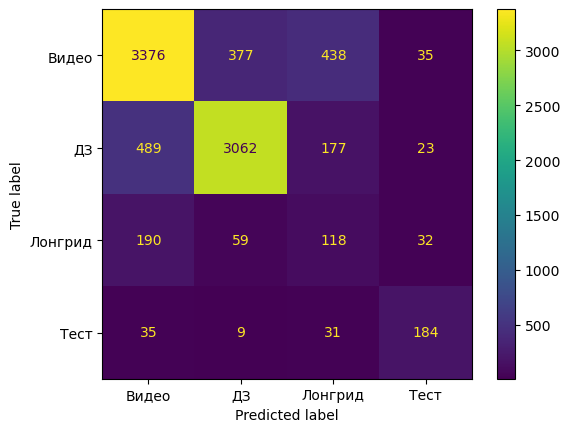

In [277]:
x, y = CLASSES, list(reversed(CLASSES))

cm = confusion_matrix(targets, preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix =cm, display_labels=CLASSES)


cm_display.plot()
plt.savefig(f"../models_metrics/model_{MODEL_ID}_heatmap.png")
plt.show()

In [278]:
labels

{'Видео': 0, 'ДЗ': 1, 'Лонгрид': 2, 'Тест': 3}